<a href="https://colab.research.google.com/github/Filimize/Project_Collection/blob/main/NLP_Competition/NLP_BESTCOMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Keyword:** CNN-LSTM, Adverserial Distribution Training(ADT), Taguchi Array, Ensembling method (Stacking), Temparature scaling and Majority vote

# Importing the files

In [ ]:
!unzip /content/nlp-for-se-2025-programming-3-1st-competition.zip

Archive:  /content/nlp-for-se-2025-programming-3-1st-competition.zip
  inflating: test_nolabel.csv        
  inflating: train.csv               
  inflating: val.csv                 


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load Data
df_train = pd.read_csv('/content/train.csv')
df_val = pd.read_csv('/content/val.csv')
df_test = pd.read_csv('/content/test_nolabel.csv')

X_train, y_train = df_train['text'].values, df_train['label'].values
X_val, y_val = df_val['text'].values, df_val['label'].values
X_test = df_test['text'].values  # No labels

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)



In [ ]:
import numpy as np
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenization and Padding
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 200

# Assuming your train, validation, and test data are in X_train, X_val, X_test
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
X_train_seq_w2v = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQ_LENGTH)
X_val_seq_w2v = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SEQ_LENGTH)
X_test_seq_w2v = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQ_LENGTH)

# Load Word2Vec embeddings (Pretrained)
word2vec = api.load('word2vec-google-news-300')

# Initialize the embedding matrix
embedding_matrix_w2v = np.zeros((MAX_VOCAB_SIZE, 300))  # 300 is the embedding dimension for Google News Word2Vec

# Get the word index from tokenizer
word_index = tokenizer.word_index

# Populate the embedding matrix with pretrained word vectors
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE and word in word2vec:
        embedding_matrix_w2v[i] = word2vec[word]


In [ ]:
import numpy as np
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenization and Padding
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 200

# Assuming your train, validation, and test data are in X_train, X_val, X_test
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
X_train_seq_glove = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQ_LENGTH)
X_val_seq_glove = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_SEQ_LENGTH)
X_test_seq_glove = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQ_LENGTH)

# Load GloVe embeddings (Pretrained)
glove = api.load('glove-wiki-gigaword-300')

# Initialize the embedding matrix
embedding_matrix_glove = np.zeros((MAX_VOCAB_SIZE, 300))  # 300 is the embedding dimension for GloVe

# Get the word index from tokenizer
word_index = tokenizer.word_index

# Populate the embedding matrix with pretrained word vectors
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE and word in glove:
        embedding_matrix_glove[i] = glove[word]


[==================================================] 100.0% 376.1/376.1MB downloaded


# MODELING PROCESS

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Conv1D, Dropout, GlobalMaxPooling1D, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.layers import LSTM, Conv1D, Dense, Lambda, RepeatVector, Permute, Multiply, Flatten, Activation
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D,
    Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate,
    BatchNormalization, Reshape, MultiHeadAttention, LayerNormalization,
    Lambda, Add
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
""" I found that the model is struggle with overfitting, therefore I propose that
adding noise (simple method) Gaussian Noise and Noise Shift(shift word into similar words)"""
def adversarial_noise(embeddings, adt_lambda):
    noise = tf.random.normal(shape=tf.shape(embeddings), mean=0.0, stddev=1.0)
    perturbed_embeddings = embeddings + adt_lambda * noise
    return perturbed_embeddings

def adversarial_noise_shift(embeddings, adt_lambda):
    shift_direction = tf.random.normal(shape=tf.shape(embeddings))
    perturbation = adt_lambda * shift_direction
    perturbed_embeddings = embeddings + perturbation
    return perturbed_embeddings

def create_model(embedding_type, model_type, adt_lambda, noise_type):
    input_layer = Input(shape=(MAX_SEQ_LENGTH,))
    if embedding_type == "Glove":
        embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=300,
                                    weights=[embedding_matrix_glove], input_length=MAX_SEQ_LENGTH,
                                    trainable=False)(input_layer)
    x = BatchNormalization()(embedding_layer)

    if noise_type == 'shift':
        perturbed_embedding = Lambda(
            lambda x: adversarial_noise_shift(x, adt_lambda),
            output_shape=lambda input_shape: input_shape
        )(x)
    else:
        perturbed_embedding = Lambda(
            lambda x: adversarial_noise(x, adt_lambda),
            output_shape=lambda input_shape: input_shape
        )(x)

    if model_type == "CNN-LSTM-V2":
        conv1_branch1 = Conv1D(128, 3, padding='same', activation='relu')(perturbed_embedding)
        conv1_branch1 = BatchNormalization()(conv1_branch1)
        conv1_branch1 = MaxPooling1D(pool_size=2)(conv1_branch1)

        conv1_branch2 = Conv1D(128, 5, padding='same', activation='relu')(perturbed_embedding)
        conv1_branch2 = BatchNormalization()(conv1_branch2)
        conv1_branch2 = MaxPooling1D(pool_size=2)(conv1_branch2)

        conv1_merged = concatenate([conv1_branch1, conv1_branch2])
        conv1_merged = Dropout(0.5)(conv1_merged)

        conv2 = Conv1D(256, 3, padding='same', activation='relu')(conv1_merged)
        conv2 = BatchNormalization()(conv2)
        conv2 = MaxPooling1D(pool_size=2)(conv2)
        conv2 = Dropout(0.5)(conv2)

        lstm = Bidirectional(LSTM(256, return_sequences=True))(conv2)
        lstm = BatchNormalization()(lstm)

        avg_pool = GlobalAveragePooling1D()(lstm)
        max_pool = GlobalMaxPooling1D()(lstm)
        x = concatenate([avg_pool, max_pool])

        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

    elif model_type == "CNN-LSTM-V3":
        conv1_branch1 = Conv1D(256, 3, padding='same', activation='relu')(perturbed_embedding)
        conv1_branch1 = BatchNormalization()(conv1_branch1)
        conv1_branch1 = MaxPooling1D(pool_size=2)(conv1_branch1)

        conv1_branch2 = Conv1D(256, 5, padding='same', activation='relu')(perturbed_embedding)
        conv1_branch2 = BatchNormalization()(conv1_branch2)
        conv1_branch2 = MaxPooling1D(pool_size=2)(conv1_branch2)

        conv1_branch3 = Conv1D(256, 7, padding='same', activation='relu')(perturbed_embedding)
        conv1_branch3 = BatchNormalization()(conv1_branch3)
        conv1_branch3 = MaxPooling1D(pool_size=2)(conv1_branch3)

        conv1_merged = concatenate([conv1_branch1, conv1_branch2, conv1_branch3])
        conv1_merged = Dropout(0.4)(conv1_merged)

        conv2 = Conv1D(512, 3, padding='same', activation='relu')(conv1_merged)
        conv2 = BatchNormalization()(conv2)
        conv2 = MaxPooling1D(pool_size=2)(conv2)
        conv2 = Dropout(0.4)(conv2)

        lstm = Bidirectional(LSTM(256, return_sequences=True))(conv2)
        lstm = BatchNormalization()(lstm)

        gru = Bidirectional(LSTM(256, return_sequences=True))(lstm)
        gru = BatchNormalization()(gru)

        additional_lstm = Bidirectional(LSTM(128, return_sequences=True))(gru)
        additional_lstm = BatchNormalization()(additional_lstm)

        avg_pool = GlobalAveragePooling1D()(additional_lstm)
        max_pool = GlobalMaxPooling1D()(additional_lstm)
        x = concatenate([avg_pool, max_pool])

        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(5, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

    optimizer = Adam(learning_rate=learning_rate_schedule)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
""" From experiment i found that the Glove vectorizor is always better than
Word2vec google-news-300 therfore i use Glove throughout experiment while testing other hyperparameter instead"""
# **Taguchi L4 Experimental Design for Glove with Noise Shift vs Gaussian Noise**
experiments = [
    ("Glove", "CNN-LSTM-V2", 6.5, 'shift'),  # Glove with Noise Shift
    ("Glove", "CNN-LSTM-V2", 7.5, 'gaussian'),
    ("Glove", "CNN-LSTM-V3", 6.5, 'gaussian'),  # Glove with Gaussian Noise
    ("Glove", "CNN-LSTM-V3", 7.5, 'shift')
]

results = []
history_logs = {}

## Start Experiments
for embedding, model_type, adt_lambda, noise_type in experiments:
    print(f"Running Experiment: {embedding}, {model_type}, ADT λ={adt_lambda}, Noise Type={noise_type}")

    # Use Glove embedding sequences for input
    X_train_input = X_train_seq_glove
    X_val_input = X_val_seq_glove
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    # Update the create_model function to use the selected noise type (Shift or Gaussian)
    model = create_model(embedding, model_type, adt_lambda, noise_type)
    history = model.fit(X_train_input, y_train, validation_data=(X_val_input, y_val),
                        epochs=200, batch_size=32, verbose=1, callbacks=[early_stopping])  # Run for 1 epoch for experimentation

    y_pred = np.argmax(model.predict(X_val_input), axis=1)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")

    results.append((embedding, model_type, adt_lambda, noise_type, accuracy))

    # Store loss and accuracy history
    history_logs[f"{embedding}_{model_type}_λ{adt_lambda}_NoiseType_{noise_type}"] = history.history

# Print results for each experiment
for result in results:
    print(f"Embedding: {result[0]}, Model: {result[1]}, ADT λ: {result[2]}, Noise Type: {result[3]}, Accuracy: {result[4]:.4f}")

Running Experiment: Glove, CNN-LSTM-V2, ADT λ=6.5, Noise Type=shift
Epoch 1/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.2208 - loss: 2.3907 - val_accuracy: 0.2733 - val_loss: 1.9752
Epoch 2/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2300 - loss: 1.8125 - val_accuracy: 0.2733 - val_loss: 1.6388
Epoch 3/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.2411 - loss: 1.6830 - val_accuracy: 0.2610 - val_loss: 1.6068
Epoch 4/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.2463 - loss: 1.6247 - val_accuracy: 0.2598 - val_loss: 1.6334
Epoch 5/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.2462 - loss: 1.6099 - val_accuracy: 0.2790 - val_loss: 1.6407
Epoch 6/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2657 - loss: 1.5883 - val_accuracy: 0.2942 - val_loss: 1.6042
Epoch 7/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2610 - loss: 1.5874 - val_accuracy: 0.2694 - val_loss: 1.6000
Epoch 8/200
260/26

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.2111 - loss: 2.3960 - val_accuracy: 0.1519 - val_loss: 3.0035
Epoch 2/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2193 - loss: 1.8655 - val_accuracy: 0.1744 - val_loss: 1.6749
Epoch 3/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.2257 - loss: 1.7096 - val_accuracy: 0.2424 - val_loss: 1.6557
Epoch 4/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2547 - loss: 1.6289 - val_accuracy: 0.2553 - val_loss: 1.6283
Epoch 5/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2583 - loss: 1.5999 - val_accuracy: 0.1924 - val_loss: 1.6753
Epoch 6/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2489 - loss: 1.5912 - val_accuracy: 0.1592 - val_loss: 1.6665
Epoch 7/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2589 - loss: 1.5901 - val_accuracy: 0.2587 - val_loss: 1.5989
Epoch 8/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.2639 - loss: 1.5793

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 70ms/step - accuracy: 0.2362 - loss: 2.1768 - val_accuracy: 0.2520 - val_loss: 1.6231
Epoch 2/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.2376 - loss: 1.6750 - val_accuracy: 0.2705 - val_loss: 1.6556
Epoch 3/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.2369 - loss: 1.6055 - val_accuracy: 0.2514 - val_loss: 1.5960
Epoch 4/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.2652 - loss: 1.5791 - val_accuracy: 0.2587 - val_loss: 1.5814
Epoch 5/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.2669 - loss: 1.5798 - val_accuracy: 0.2942 - val_loss: 1.5760
Epoch 6/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2955 - loss: 1.5634 - val_accuracy: 0.2835 - val_loss: 1.6237
Epoch 7/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.3254 - loss: 1.5283 - val_accuracy: 0.3296 - val_loss: 1.5062
Epoch 8/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.3427 - loss: 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.2154 - loss: 2.1043 - val_accuracy: 0.2582 - val_loss: 1.6575
Epoch 2/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.2345 - loss: 1.6619 - val_accuracy: 0.2137 - val_loss: 1.6229
Epoch 3/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.2474 - loss: 1.5978 - val_accuracy: 0.2739 - val_loss: 1.5845
Epoch 4/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.2595 - loss: 1.5821 - val_accuracy: 0.2632 - val_loss: 1.5774
Epoch 5/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.2640 - loss: 1.5806 - val_accuracy: 0.2587 - val_loss: 1.5812
Epoch 6/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.2695 - loss: 1.5718 - val_accuracy: 0.3054 - val_loss: 1.5750
Epoch 7/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.2835 - loss: 1.5652 - val_accuracy: 0.3211 - val_loss: 1.5640
Epoch 8/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.3135 - loss: 1

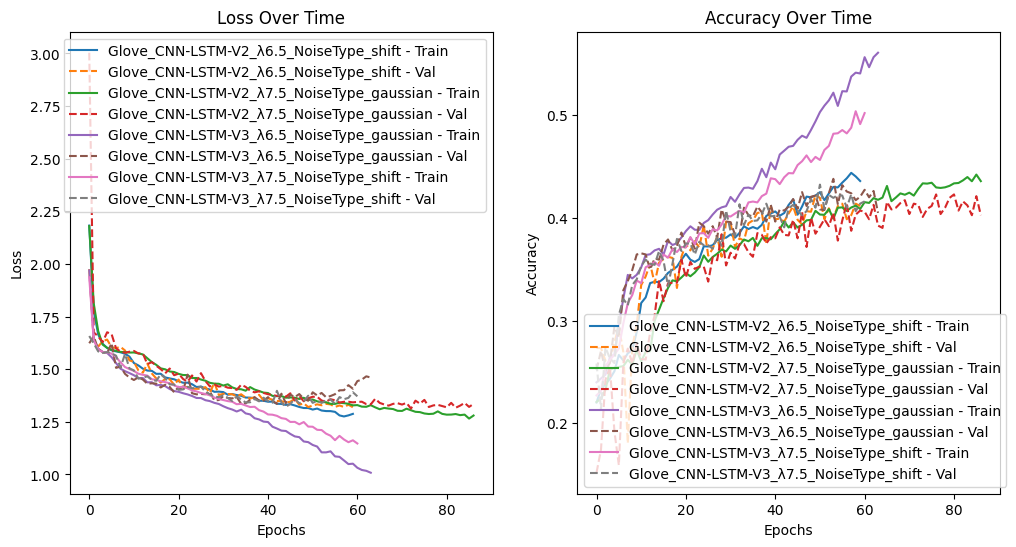

In [ ]:
# # **Taguchi Analysis (S/N Ratio)**
# df_results = pd.DataFrame(results, columns=['Embedding', 'Model', 'ADT_Lambda', 'Accuracy'])

# # Compute S/N Ratio (Higher-the-Better)
# df_results['SNR'] = 10 * np.log10(df_results['Accuracy']**2 / (1 - df_results['Accuracy'])**2)

# # **Select the Best Model**
# best_experiment = df_results.loc[df_results['Accuracy'].idxmax()]
# print("\nBest Configuration:")
# print(best_experiment)

# **Plot Loss & Accuracy Curves**
plt.figure(figsize=(12, 6))

for key, history in history_logs.items():
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label=f"{key} - Train")
    plt.plot(history['val_loss'], label=f"{key} - Val",linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Time")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label=f"{key} - Train")
    plt.plot(history['val_accuracy'], label=f"{key} - Val",linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Time")
    plt.legend()

plt.show()

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
# Perform majority voting
from scipy.stats import mode

In [ ]:
# **Final Training on Full Data**
final_model = create_model('Glove','CNN-LSTM-V3',6.5,'gaussian')
X_train_final = X_train_seq_glove
X_val_final =  X_val_seq_glove
X_test_final = X_test_seq_glove


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from scipy.stats import mode
import tensorflow as tf

# Function to apply temperature scaling (logits -> softmax with temperature)
def apply_temperature_scaling(logits, temperature):
    return tf.nn.softmax(logits / temperature)

# Function to optimize temperature (find the best temperature using the validation set)
def optimize_temperature(logits, true_labels):
    best_temperature = 1.0
    best_loss = float('inf')

    # Try a range of temperatures to find the best one (you can fine-tune this range)
    temperatures = np.linspace(0.5, 2.0, 20)

    for temp in temperatures:
        scaled_logits = apply_temperature_scaling(logits, temp)
        probs = scaled_logits.numpy()
        loss = log_loss(true_labels, probs)

        if loss < best_loss:
            best_loss = loss
            best_temperature = temp

    return best_temperature

# **Create Ensemble of Models**
num_models = 5  # Number of models in the ensemble
models = []
history_list = []  # To store the training history of each model

# Train multiple models and store them
for _ in range(num_models):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=25, restore_best_weights=True)
    model = create_model('Glove', 'CNN-LSTM-V2', 6,'gaussian')
    history = model.fit(X_train_final, y_train, validation_data=(X_val_final, y_val), epochs=200, batch_size=32, verbose=1, callbacks=[early_stopping])
    models.append(model)
    history_list.append(history)  # Store the history of this model
    print(f"Model {_ + 1} trained.")

# **Collect logits from models for validation set (to optimize temperature)**
logits_list_val = []
for model in models:
    logits = model.predict(X_val_final)  # Get logits from validation set (not softmax)
    logits_list_val.append(logits)

# Stack all the logits for validation
logits_array_val = np.stack(logits_list_val, axis=0)

# **Optimize Temperature for All Models on the Validation Set**
best_temperature = optimize_temperature(np.mean(logits_array_val, axis=0), y_val)

# **Apply Temperature Scaling to Final Logits**
scaled_logits = apply_temperature_scaling(np.mean(logits_array_val, axis=0), best_temperature)

# **Collect logits for test set**
logits_list_test = []
for model in models:
    logits = model.predict(X_test_final)  # Get logits from test set
    logits_list_test.append(logits)

# Stack all the logits for test
logits_array_test = np.stack(logits_list_test, axis=0)

# **Apply Temperature Scaling to Test Set Logits (using the best temperature found)**
scaled_logits_test = apply_temperature_scaling(np.mean(logits_array_test, axis=0), best_temperature)

# **Final Prediction from Softmax Averaging**
y_test_pred_softmax_avg = np.argmax(scaled_logits_test, axis=1)

# **Majority Voting**
# Convert logits into predicted classes for each model (argmax of logits)
predicted_classes = np.argmax(logits_array_test, axis=-1)

y_test_pred_majority = mode(predicted_classes, axis=0)[0].flatten()

# **Final Prediction: Combine Softmax Average and Majority Voting**
final_predictions = np.stack([y_test_pred_softmax_avg, y_test_pred_majority], axis=1)

# Choose the prediction method you prefer (average softmax or majority vote)
final_predictions = y_test_pred_softmax_avg  # Change to y_test_pred_majority for majority vote

Epoch 1/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2240 - loss: 2.1822 - val_accuracy: 0.2576 - val_loss: 2.2115
Epoch 2/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.2320 - loss: 1.6710 - val_accuracy: 0.2683 - val_loss: 1.6879
Epoch 3/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2681 - loss: 1.5872 - val_accuracy: 0.2711 - val_loss: 1.5921
Epoch 4/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2578 - loss: 1.5882 - val_accuracy: 0.2762 - val_loss: 1.5867
Epoch 5/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.2722 - loss: 1.5782 - val_accuracy: 0.2750 - val_loss: 1.6050
Epoch 6/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2603 - loss: 1.5840 - val_accuracy: 0.2778 - val_loss: 1.6434
Epoch 7/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.2598 - loss: 1.5789 - val_accuracy: 0.2913 - val_loss: 1.6100
Epoch 8/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.2632 - loss: 1.5

In [ ]:
final_predictions_avg = y_test_pred_softmax_avg  # Change to y_test_pred_majority for majority vote
final_predictions_major = y_test_pred_majority

In [ ]:
# Save Predictions (Final predictions for test set)
pd.DataFrame({'id': df_test['id'],'label_avg': final_predictions_avg, 'label_major': final_predictions_major}).to_csv('/content/Ens4.csv', index=False)

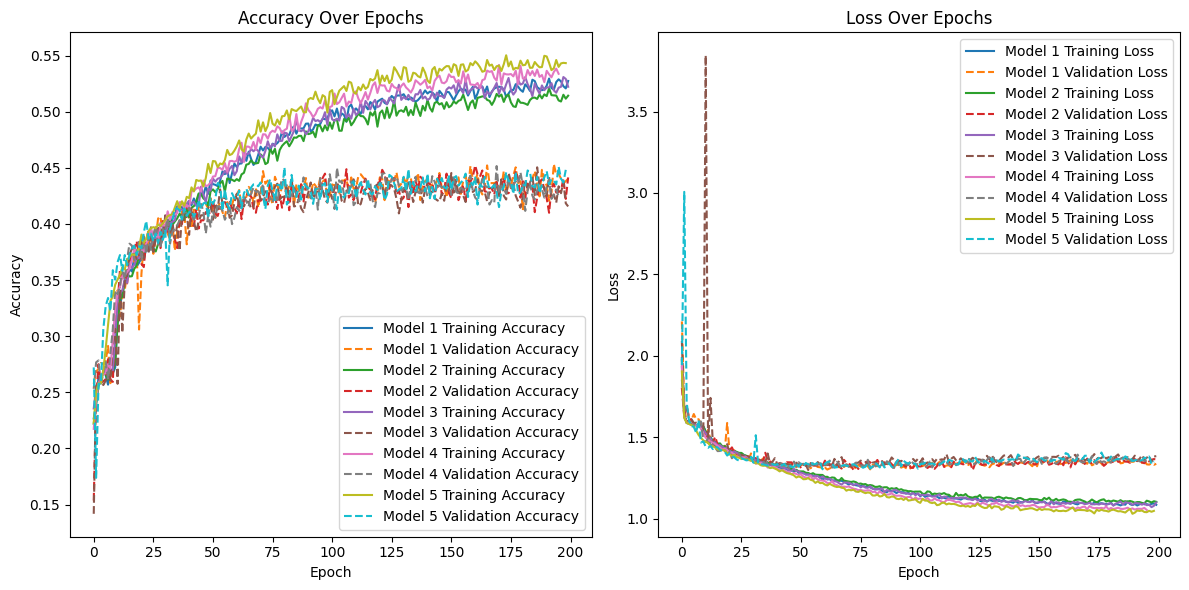

In [ ]:
# **Plot Training History**
# Plot training and validation accuracy and loss for all models
plt.figure(figsize=(12, 6))

# Loop through each model's history and plot
for i, history in enumerate(history_list):
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f'Model {i+1} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Model {i+1} Validation Accuracy', linestyle='--')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f'Model {i+1} Training Loss')
    plt.plot(history.history['val_loss'], label=f'Model {i+1} Validation Loss', linestyle='--')

plt.subplot(1, 2, 1)
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
